In [21]:
import logging
import sys
import os 
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [22]:
from llama_index.llms.databricks import Databricks
from langchain_huggingface import HuggingFaceEmbeddings
from llama_index.embeddings.langchain import LangchainEmbedding
from llama_index.core import Settings


Settings.llm = Databricks(
    model="databricks-meta-llama-3-1-70b-instruct",
    api_key=os.environ["DATABRICKS_TOKEN"],
    api_base="https://adb-7215147325717155.15.azuredatabricks.net/serving-endpoints",
)
Settings.embed_model = LangchainEmbedding(HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
Use pytorch device_name: cpu
Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


c:\Users\NailFerroukhi\miniconda3\envs\sid\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
from llama_index.core import SimpleDirectoryReader

docs = SimpleDirectoryReader("../../data/pdf/resume").load_data()

In [7]:
from llama_index.core.node_parser import SemanticSplitterNodeParser

splitter = SemanticSplitterNodeParser(
    buffer_size=2, breakpoint_percentile_threshold=75, embed_model= Settings.embed_model
)

In [8]:
nodes = splitter.get_nodes_from_documents(docs)

In [9]:
for i in range(len(nodes)):    
    print(f"Split {i}", nodes[i].get_content())

Split 0    
 
   
  
 
Par Sid Ahmed FERROUKHI  
Enseignant & Chercheur  
 
Les effets sur la sécurité alimentaire des politiques de soutien à l’Agriculture et 
à l’Alimentation (2000 -2020)  : Situation et porspective (2035 -2050) en Algérie  
Novembre  2021  
Split 1    
 
  2 
 Table des Matières   
 
TABLE DES MATIERES ................................ ................................ ................................ ................................ .. 2 
I- INTRODUCTION GENERALE  ................................ ................................ ................................ .............  5 
II- APPROCHE THEORIQUE ET CADRE CONCEPTUEL  ................................ ................................ ... 17 
III- RETROSPECTIVE ET ETAT DE LA SECURITE ALIMENTAIRE ET DES SYSTEMES 
PRODUCTIFS DE L’AGRICULTURE ET LA PECHE  ................................ ................................ ..........  21 
III.1 POUR LA SITUATION MACRO -ECONOMIQUE  ................................ ......

[83, 831, 223, 75, 278, 344, 41, 232, 73, 6, 166, 51, 376, 262, 153, 323, 218, 87, 92, 305, 561, 173, 47, 65, 265, 102, 95, 366, 33, 280, 70, 770, 190, 24, 3, 149, 309, 174, 98, 258, 363, 12, 174, 164, 586, 82, 160, 296, 102, 319, 280, 171, 32, 313, 3, 357, 283, 490, 68, 326, 132, 52, 355, 381, 94, 133, 266, 452, 113, 96, 125, 408, 170, 217, 328, 180, 285, 54, 151, 163, 326, 210, 529, 183, 172, 250, 81, 176, 25, 169, 51, 233, 367, 264, 47, 68, 197, 383, 19, 27, 89, 10, 244, 54, 146, 435, 101, 68, 131, 116, 356, 94, 129, 40, 555, 201, 37, 214, 22, 331, 360, 3, 72, 38, 197, 128, 93, 283, 30, 180, 29, 171, 233, 10, 288, 80, 367, 166, 71, 18, 523, 916, 14, 30, 36, 115, 37, 52, 584, 10, 227, 74, 175, 33, 184, 424, 256, 28, 297, 92, 379, 148, 43, 128, 71, 144, 231, 82, 243, 175, 254, 7, 283, 25, 120, 316, 70, 388, 84, 166, 724, 99, 158, 190, 264, 458, 192, 363, 248, 3, 417, 104, 321, 256, 170, 10, 464, 345, 108, 47, 96, 236, 202, 23, 138, 126, 273, 229, 28, 143, 33, 72, 45, 236, 140, 62, 184

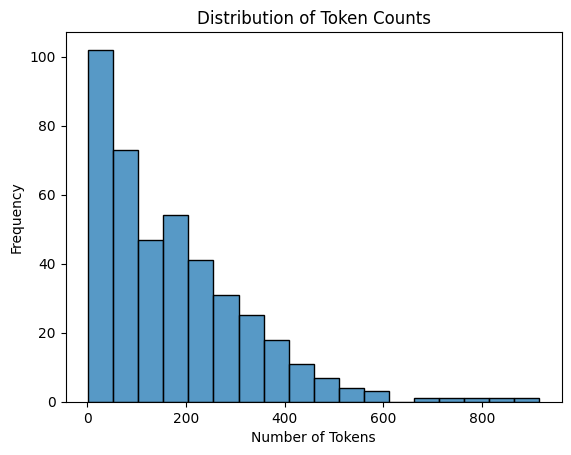

In [16]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-70B")

import seaborn as sns
import matplotlib.pyplot as plt

token_counts = []
for i in range(len(nodes)):
    tokens = tokenizer.tokenize(nodes[i].get_content())
    num_tokens = len(tokens)
    token_counts.append(num_tokens)
print(token_counts)    
sns.histplot(token_counts, kde=False)
plt.title("Distribution of Token Counts")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [17]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex(nodes)

In [23]:
retriever = index.as_retriever()
query_engine = index.as_query_engine()

In [ ]:
import pandas as pd
from datasets import Dataset

# Read test set
testset = pd.read_parquet("../../data/parquet/dataset.parquet")

questions = testset["question"].tolist()
answers = []
contexts = []

# Inference
for query in questions:
  answers.append(query_engine.query(query).response)
  contexts.append([retriever.retrieve(query)[0].node.text])

In [25]:
# To dict
data = {
    "question": testset["question"].tolist(),
    "answer": answers,
    "contexts": contexts,
    "ground_truth": testset["ground_truth"].tolist()
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)
print(dataset)

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 215
})


In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

df = result.to_pandas()

In [28]:
df

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Quelle a été l'évolution de la balance aliment...,La balance alimentaire de l'Algérie a connu un...,[Le taux de couverture des importations agrico...,La balance alimentaire de l'Algérie a été défi...,1.0,1.000000,0.666667,0.968123
1,Quel est l'inconvénient de ne pas prendre en c...,Cela a pour conséquence de mettre sur le même ...,[ \n \n 76 \n Comme il a déjà été souligné ...,L'inconvénient de ne pas prendre en compte la ...,1.0,1.000000,1.000000,0.871267
2,Qu'est-ce que la sécurité alimentaire et comme...,La sécurité alimentaire est un concept qui eng...,[ \n \n 7 \n 17. Intégrer simultanément dan...,La sécurité alimentaire est liée à la croissan...,1.0,0.000000,0.000000,0.914581
3,Quels sont les principaux éléments qui caracté...,Les principaux éléments qui caractérisent la p...,[ \n \n 20 \n 55. Pour les politiques agric...,Les principaux éléments qui caractérisent la p...,1.0,0.304348,1.000000,1.000000
4,Quel est le rôle de la prospective stratégique...,La prospective stratégique joue un rôle crucia...,[50. Une batterie large de méthodes et d’outil...,La prospective stratégique joue un rôle crucia...,1.0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
210,Here is a rewritten question that conveys the ...,The relationship between productivity gains an...,"[Bessaoud (2004) , au sujet du Plan National ...",Productivity gains have positively impacted Al...,1.0,0.000000,0.555556,0.000000
211,Here is a rewritten version of the question th...,L'évaluation de l'impact des politiques agrico...,[L’analyse comparative des soutiens à l’agricu...,L’évaluation d’impact Ex-post de type « récapi...,1.0,0.000000,1.000000,0.897629
212,Here is a rewritten version of the question th...,Les politiques agricoles et halieutiques ont u...,[ \n \n 6 \n financières internationales co...,Les politiques agricoles et halieutiques ont u...,1.0,1.000000,0.777778,0.918674
213,Here is a rewritten question that conveys the ...,"To tap into Algeria's maritime potential, a co...",[ \n \n 6 \n financières internationales co...,"To tap into Algeria's maritime potential, an i...",1.0,0.000000,0.000000,0.913633


In [27]:
# Compute the average of each column
averages = df[["context_precision", "context_recall", "faithfulness", "answer_relevancy"]].mean()

print(averages)

context_precision    0.710280
context_recall       0.295345
faithfulness         0.475851
answer_relevancy     0.711467
dtype: float64
